In [1]:
import nltk 
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem.porter import PorterStemmer

import regex as re

## Data Exploration

In [6]:
train = pd.read_csv('./data/train.csv')
train.head()

posts_combined subreddit  is_tv
0  Official Discussion Weekly Megathread (Pet Sem...    movies      0
1  Twenty years ago, an upstart animator named Mi...    movies      0
2  10 years later and Avatar still holds the reco...    movies      0
3  ‘Hellboy’ Receives Rare R 18+ Rating in Austra...    movies      0
4  In 2015, Maggie Gyllenhaal, then 37, was told ...    movies      0

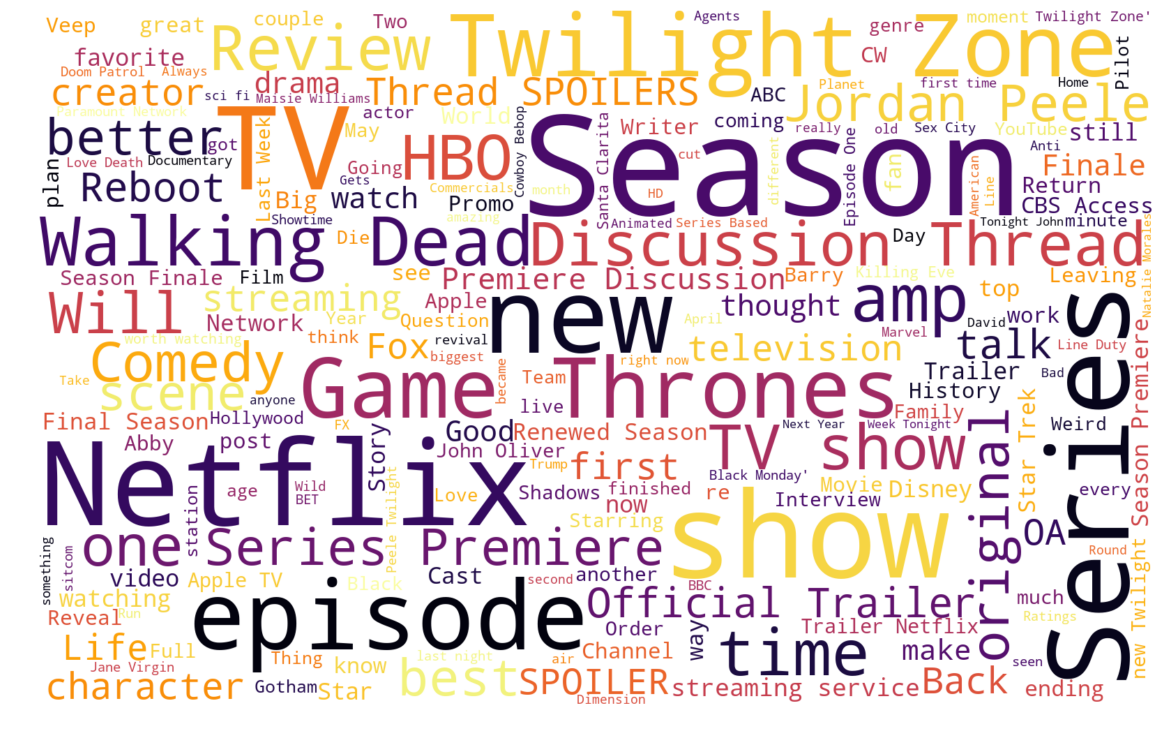

In [7]:
# returns a word cloud of tv shows using raw text
class_one = train[train['is_tv'] == 1]
one_string = []
# iterates over values assigned to class_one and adds to an empty list
for t in class_one.posts_combined:
    one_string.append(t)
one_string = pd.Series(one_string).str.cat(sep=' ')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(width=1600, height=1000,
                      max_font_size=200,
                      colormap='inferno', 
                      background_color='white').generate(one_string)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

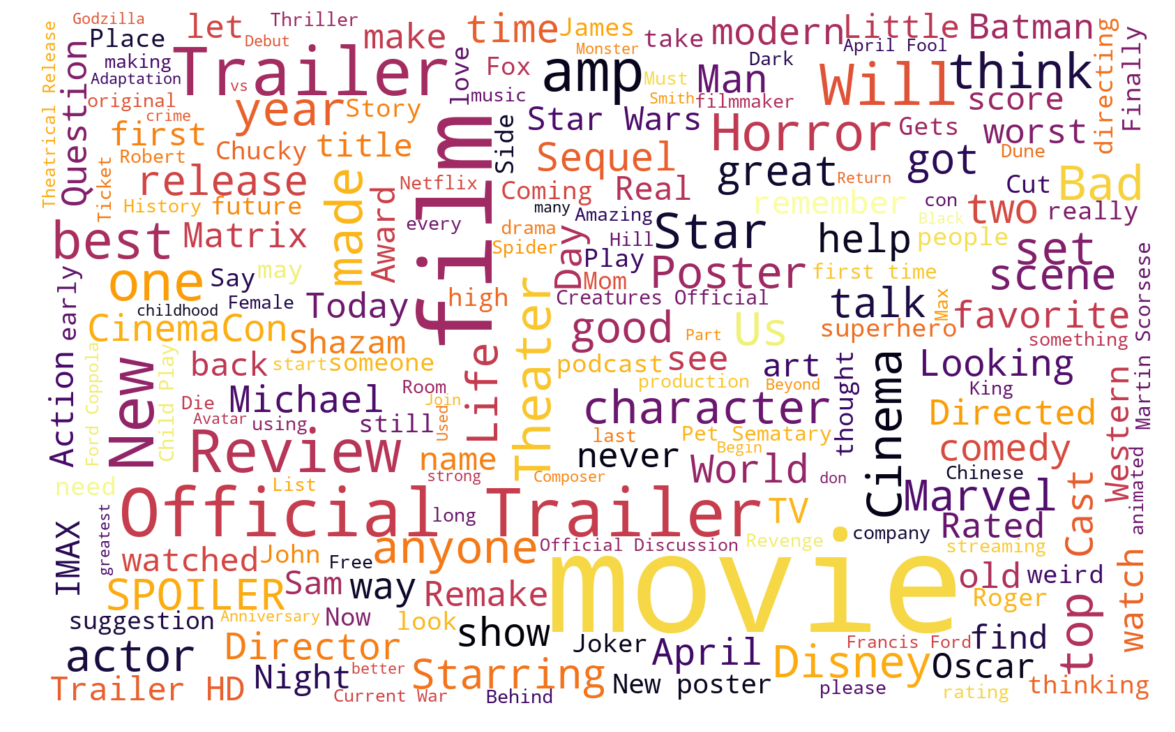

In [8]:
# returns a word cloud of movies using raw text
class_zero = train[train['is_tv'] == 0]
zero_string = []
for t in class_zero.posts_combined:
    zero_string.append(t)
zero_string = pd.Series(zero_string).str.cat(sep=' ')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(width=1600, height=1000,
                      max_font_size=200,
                      colormap='inferno', 
                      background_color='white').generate(zero_string)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

A first look at the words in each category reveals that there are overlaps of words. For instance, the word ***Netflix*** shows up prominently on both subreddits. This makes sense because the streaming platform has both movies and tv shows. Another word is ***spoiler*** or ***spoilers***. We need to find a way to deal with this overlap in order to train our model to accurately classify each category.

## Preprocessing

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train['posts_combined'],
                                                    train['is_tv'],
                                                    test_size = 0.30,
                                                    random_state = 42)

### Step One: Remove HTML Code Artifacts

In [10]:
X_train[1685]

'[Kim\'s Convenience] Season Finale - S03E13 - "Lord of the Ring" - Discussion Thread (SPOILERS)'

In [11]:
from bs4 import BeautifulSoup             

# Initialize the BeautifulSoup object on a single movie review     
example1 = BeautifulSoup(X_train[1685])

# Print the raw review and then the output of get_text(), for 
# comparison
print(X_train[1685])
print()
print(example1.get_text())

[Kim's Convenience] Season Finale - S03E13 - "Lord of the Ring" - Discussion Thread (SPOILERS)

[Kim's Convenience] Season Finale - S03E13 - "Lord of the Ring" - Discussion Thread (SPOILERS)


### Step Two: Remove Punctuations (Regex)

In [12]:
# Use regular expressions to do a find-and-replace
letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example1.get_text())   # The text to search

In [13]:
letters_only

' Kim s Convenience  Season Finale   S  E      Lord of the Ring    Discussion Thread  SPOILERS '

In [14]:
# Convert letters_only to lower case.
lower_case = letters_only.lower()

# Split lower_case up at each space.
words = lower_case.split()

In [15]:
words

['kim',
 's',
 'convenience',
 'season',
 'finale',
 's',
 'e',
 'lord',
 'of',
 'the',
 'ring',
 'discussion',
 'thread',
 'spoilers']

### Step Three: Remove Stop Words

In [16]:
from nltk.corpus import stopwords

In [17]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
words = [w for w in words if w not in stopwords.words("english")]

In [19]:
print(words)

['kim', 'convenience', 'season', 'finale', 'e', 'lord', 'ring', 'discussion', 'thread', 'spoilers']


### Step Four: Combine our cleaning into one function

In [20]:
def post_to_words(raw_post):
    # Function to convert a post to a string of words
    # The input is a single string (a raw movie/tv post), and 
    # the output is a single string (a preprocessed movie/tv post)
    
    # 1. Remove HTML.
    post_text = BeautifulSoup(raw_post).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 5. Remove stop words.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

### Step Five: Applying our Function

In [22]:
# applies the post_to_words function on the minutes column
# and creates a new column with clean text

train['clean_text'] = train['posts_combined'].apply(post_to_words)
train.head()

posts_combined subreddit  is_tv  \
0  Official Discussion Weekly Megathread (Pet Sem...    movies      0   
1  Twenty years ago, an upstart animator named Mi...    movies      0   
2  10 years later and Avatar still holds the reco...    movies      0   
3  ‘Hellboy’ Receives Rare R 18+ Rating in Austra...    movies      0   
4  In 2015, Maggie Gyllenhaal, then 37, was told ...    movies      0   

                                          clean_text  
0  official discussion weekly megathread pet sema...  
1  twenty years ago upstart animator named mike j...  
2  years later avatar still holds record highest ...  
3  hellboy receives rare r rating australia stron...  
4  maggie gyllenhaal told old play love interest ...

In [23]:
# import tokenizer and stemmer
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize 

In [24]:
# define a function that takes in a text
# and tokenizes and stems each word
def stem_text(text):    
    stm = PorterStemmer()
    tokenized = word_tokenize(text)
    stem_tokes = []
    for toke in tokenized:
        stem_tokes.append(stm.stem(toke))
    stem_tokes

    combined = ''
    for stemmed in stem_tokes:
        combined += stemmed + ' '
    return combined


In [25]:
# define a function that takes in a text
# and tokenizes and lemmatizes that text
def lem_text(text):    
    lem = WordNetLemmatizer()
    tokenizer = RegexpTokenizer('[A-Z]\w+')
    tokenized = tokenizer.tokenize(text)
    lemmed_tokes = []
    for toke in tokenized:
        lemmed_tokes.append(lem.lemmatize(toke))
    lemmed_tokes

    combined = ''
    for lemmed in lemmed_tokes:
        combined += lemmed + ' '
    return combined

In [26]:
train['stemmed_text'] = train['posts_combined'].apply(stem_text)
train.head()

posts_combined subreddit  is_tv  \
0  Official Discussion Weekly Megathread (Pet Sem...    movies      0   
1  Twenty years ago, an upstart animator named Mi...    movies      0   
2  10 years later and Avatar still holds the reco...    movies      0   
3  ‘Hellboy’ Receives Rare R 18+ Rating in Austra...    movies      0   
4  In 2015, Maggie Gyllenhaal, then 37, was told ...    movies      0   

                                          clean_text  \
0  official discussion weekly megathread pet sema...   
1  twenty years ago upstart animator named mike j...   
2  years later avatar still holds record highest ...   
3  hellboy receives rare r rating australia stron...   
4  maggie gyllenhaal told old play love interest ...   

                                        stemmed_text  
0  offici discuss weekli megathread ( pet sematar...  
1  twenti year ago , an upstart anim name mike ju...  
2  10 year later and avatar still hold the record...  
3  ‘ hellboy ’ receiv rare R 18+ rate in australi...  
4  In 2015 , maggi gyllenha , then 37 , wa told s...

In [27]:
train['lemmed_text'] = train['posts_combined'].apply(lem_text)
train.head()

posts_combined subreddit  is_tv  \
0  Official Discussion Weekly Megathread (Pet Sem...    movies      0   
1  Twenty years ago, an upstart animator named Mi...    movies      0   
2  10 years later and Avatar still holds the reco...    movies      0   
3  ‘Hellboy’ Receives Rare R 18+ Rating in Austra...    movies      0   
4  In 2015, Maggie Gyllenhaal, then 37, was told ...    movies      0   

                                          clean_text  \
0  official discussion weekly megathread pet sema...   
1  twenty years ago upstart animator named mike j...   
2  years later avatar still holds record highest ...   
3  hellboy receives rare r rating australia stron...   
4  maggie gyllenhaal told old play love interest ...   

                                        stemmed_text  \
0  offici discuss weekli megathread ( pet sematar...   
1  twenti year ago , an upstart anim name mike ju...   
2  10 year later and avatar still hold the record...   
3  ‘ hellboy ’ receiv rare R 18+ rate in australi...   
4  In 2015 , maggi gyllenha , then 37 , wa told s...   

                                         lemmed_text  
0  Official Discussion Weekly Megathread Pet Sema...  
1                 Twenty Mike Judge At Office Space   
2                                            Avatar   
3  Hellboy Receives Rare Rating Australia Strong ...  
4                          In Maggie Gyllenhaal Any

## Extract Nouns from each Document

In [29]:
import spacy

In [30]:
nlp = spacy.load('en')

In [31]:
# define a function to extract a text's nouns 
# and return them in a single string,
# so that the string can then be added back into the dataframe

def extract_noun(text):
    document = nlp(text)
    nouns = []
    for token in document:
        if token.pos_ == 'Noun':
            nouns.append(str(token))   
    #print(nouns)
    combined = ''
    for token in nouns:
        combined += token + ' '
    return combined

In [35]:
extract_noun(train['lemmed_text'][1])

''

In [36]:
# train['nouns_from_lemmed'] = train['lemmed_text'].apply(extract_noun)
# train.head()

posts_combined subreddit  is_tv  \
0  Official Discussion Weekly Megathread (Pet Sem...    movies      0   
1  Twenty years ago, an upstart animator named Mi...    movies      0   
2  10 years later and Avatar still holds the reco...    movies      0   
3  ‘Hellboy’ Receives Rare R 18+ Rating in Austra...    movies      0   
4  In 2015, Maggie Gyllenhaal, then 37, was told ...    movies      0   

                                          clean_text  \
0  official discussion weekly megathread pet sema...   
1  twenty years ago upstart animator named mike j...   
2  years later avatar still holds record highest ...   
3  hellboy receives rare r rating australia stron...   
4  maggie gyllenhaal told old play love interest ...   

                                        stemmed_text  \
0  offici discuss weekli megathread ( pet sematar...   
1  twenti year ago , an upstart anim name mike ju...   
2  10 year later and avatar still hold the record...   
3  ‘ hellboy ’ receiv rare R 18+ rate in australi...   
4  In 2015 , maggi gyllenha , then 37 , wa told s...   

                                         lemmed_text nouns_from_lemmed  
0  Official Discussion Weekly Megathread Pet Sema...                    
1                 Twenty Mike Judge At Office Space                     
2                                            Avatar                     
3  Hellboy Receives Rare Rating Australia Strong ...                    
4                          In Maggie Gyllenhaal Any

In [39]:
train.tail()

posts_combined   subreddit  is_tv  \
2056  The amazing climax of Miami Vice Season 2 Epis...  television      1   
2057  ‘Merry Happy Whatever’: Bridgit Mendler, Brent...  television      1   
2058   How many streaming services do you subscribe to?  television      1   
2059  Cary Joji Fukunaga ("Maniac") Explains Why TV ...  television      1   
2060  Ryan Murphy’s ‘The Politician’ to Premiere on ...  television      1   

                                             clean_text  \
2056  amazing climax miami vice season episode buses...   
2057  merry happy whatever bridgit mendler brent mor...   
2058                  many streaming services subscribe   
2059  cary joji fukunaga maniac explains tv film ble...   
2060          ryan murphy politician premiere september   

                                           stemmed_text  \
2056  the amaz climax of miami vice season 2 episod ...   
2057  ‘ merri happi whatev ’ : bridgit mendler , bre...   
2058       how mani stream servic do you subscrib to ?    
2059  cari joji fukunaga ( `` maniac '' ) explain wh...   
2060  ryan murphi ’ s ‘ the politician ’ to premier ...   

                                            lemmed_text nouns_from_lemmed  
2056  The Miami Vice Season Episode Out Where Buses ...                    
2057  Merry Happy Whatever Bridgit Mendler Brent Mor...                    
2058                                               How                     
2059  Cary Joji Fukunaga Maniac Explains Why TV Film...                    
2060     Ryan Murphy The Politician Premiere September

**We are unable to extract any nouns from the text. Therefore, we drop this column.** 

In [43]:
train.drop('nouns_from_lemmed', axis=1, inplace=True)

In [44]:
# define a function to extract a text's proper nouns 
# and return them in a single string,
# so that the string can then be added back into the dataframe

def extract_PROPN(text):
    document = nlp(text)
    PROPN = []
    for token in document:
        if token.pos_ == 'PROPN':
            PROPN.append(str(token))   
    #print(PROPN)
    combined = ''
    for token in PROPN:
        combined += token + ' '
    return combined

In [46]:
extract_PROPN(train['lemmed_text'][0])

'Discussion Weekly Megathread Pet Sematary Shazam Unicorn Store '

In [48]:
train['pnouns_from_lemmed'] = train['lemmed_text'].apply(extract_PROPN)
train.head()

posts_combined subreddit  is_tv  \
0  Official Discussion Weekly Megathread (Pet Sem...    movies      0   
1  Twenty years ago, an upstart animator named Mi...    movies      0   
2  10 years later and Avatar still holds the reco...    movies      0   
3  ‘Hellboy’ Receives Rare R 18+ Rating in Austra...    movies      0   
4  In 2015, Maggie Gyllenhaal, then 37, was told ...    movies      0   

                                          clean_text  \
0  official discussion weekly megathread pet sema...   
1  twenty years ago upstart animator named mike j...   
2  years later avatar still holds record highest ...   
3  hellboy receives rare r rating australia stron...   
4  maggie gyllenhaal told old play love interest ...   

                                        stemmed_text  \
0  offici discuss weekli megathread ( pet sematar...   
1  twenti year ago , an upstart anim name mike ju...   
2  10 year later and avatar still hold the record...   
3  ‘ hellboy ’ receiv rare R 18+ rate in australi...   
4  In 2015 , maggi gyllenha , then 37 , wa told s...   

                                         lemmed_text  \
0  Official Discussion Weekly Megathread Pet Sema...   
1                 Twenty Mike Judge At Office Space    
2                                            Avatar    
3  Hellboy Receives Rare Rating Australia Strong ...   
4                          In Maggie Gyllenhaal Any    

                                  pnouns_from_lemmed  
0  Discussion Weekly Megathread Pet Sematary Shaz...  
1                                 Mike Judge Office   
2                                                     
3  Hellboy Rare Rating Australia Strong Bloody Vi...  
4                             Maggie Gyllenhaal Any

# Visualizations 

## Word Clouds

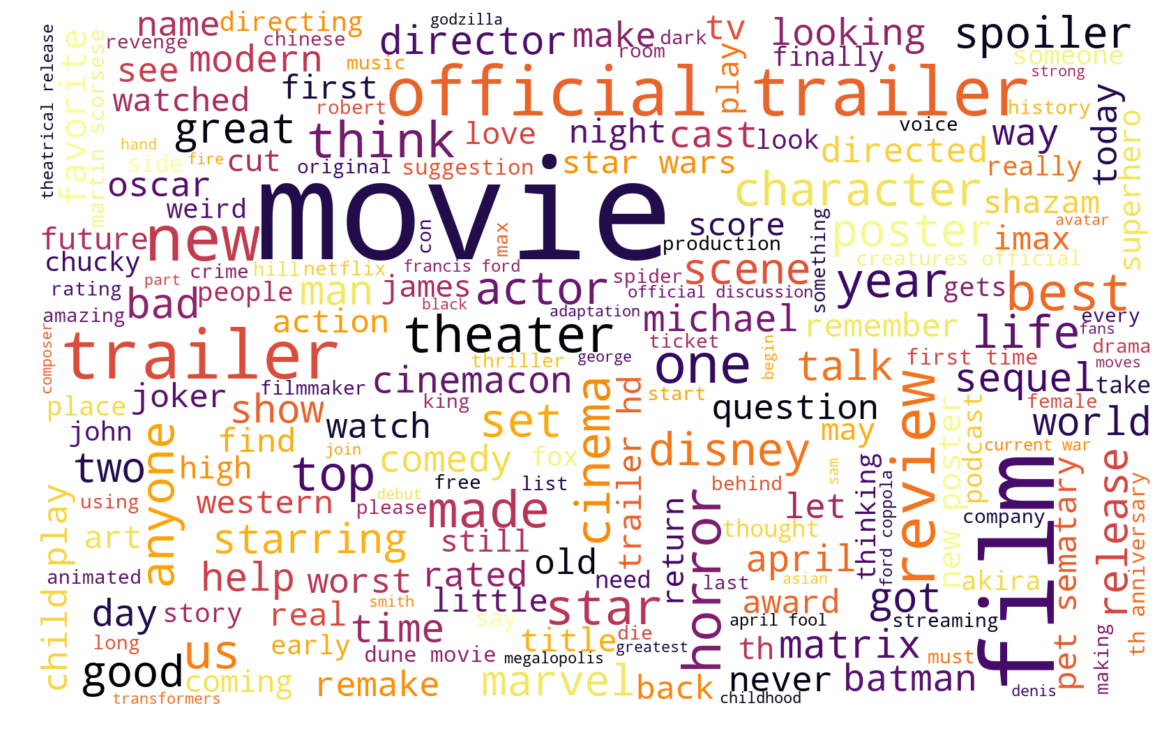

In [49]:
# returns a word cloud of movie related words using clean text
class_zero = train[train['is_tv'] == 0]
zero_string = []
for t in class_zero.clean_text:
    zero_string.append(t)
zero_string = pd.Series(zero_string).str.cat(sep=' ')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(width=1600, height=1000,
                      max_font_size=200,
                      colormap='inferno', 
                      background_color='white').generate(zero_string)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

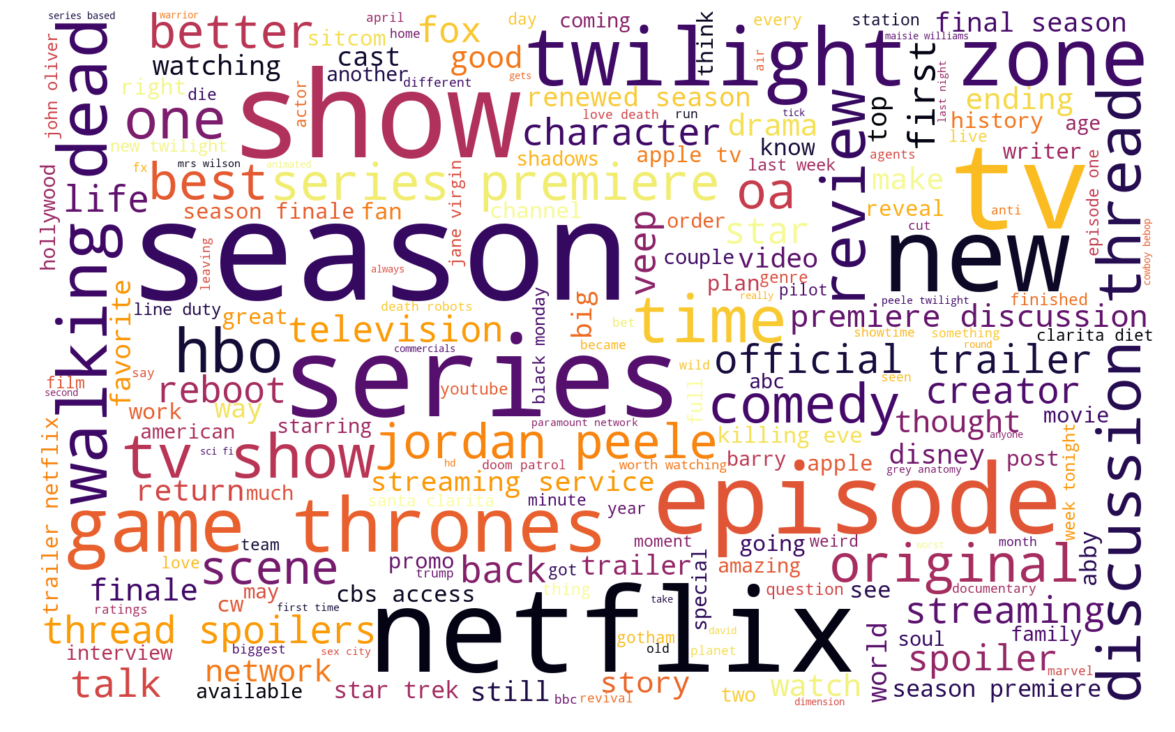

In [50]:
# returns a word cloud of tv related words using clean text
class_zero = train[train['is_tv'] == 1]
zero_string = []
for t in class_zero.clean_text:
    zero_string.append(t)
zero_string = pd.Series(zero_string).str.cat(sep=' ')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(width=1600, height=1000,
                      max_font_size=200,
                      colormap='inferno', 
                      background_color='white').generate(zero_string)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Visually, we observe that there is less overlap between words in both categories. The preprocessing of the text may have helped address the concern we initially had.** 

## Visualizing Proper Nouns

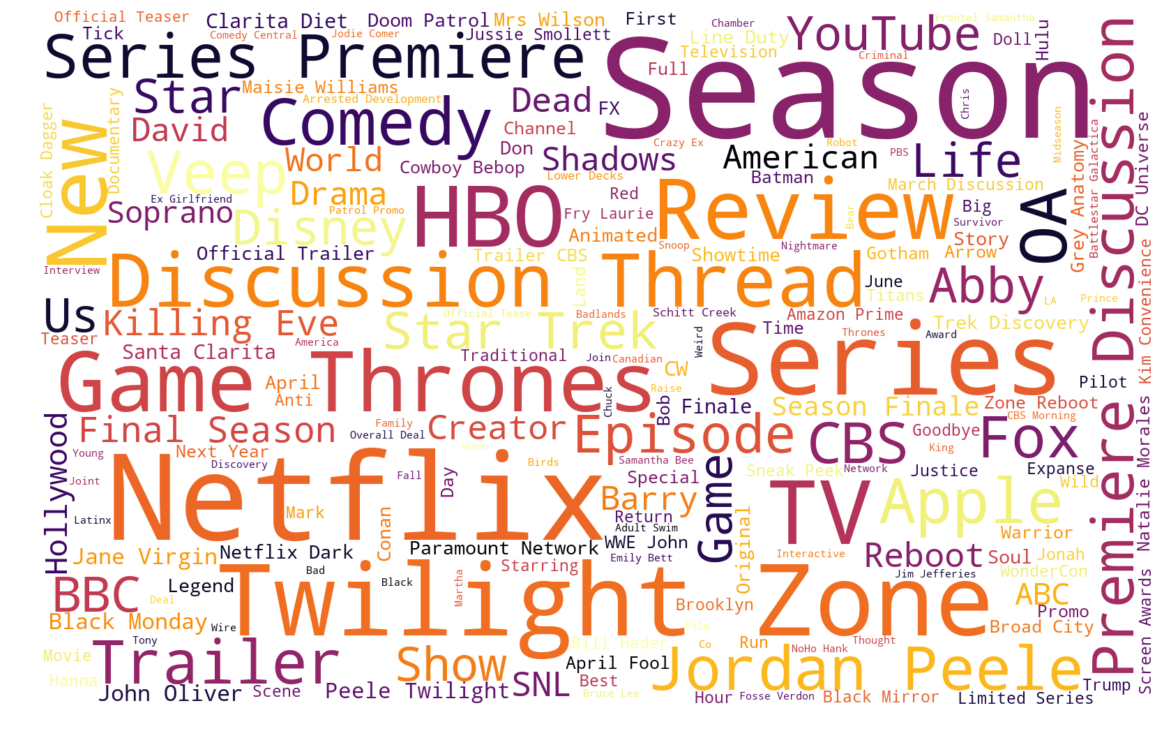

In [52]:
# returns a word cloud of tv related words using proper nouns
class_zero = train[train['is_tv'] == 1]
zero_string = []
for t in class_zero.pnouns_from_lemmed:
    zero_string.append(t)
zero_string = pd.Series(zero_string).str.cat(sep=' ')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(width=1600, height=1000,
                      max_font_size=200,
                      colormap='inferno', 
                      background_color='white').generate(zero_string)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

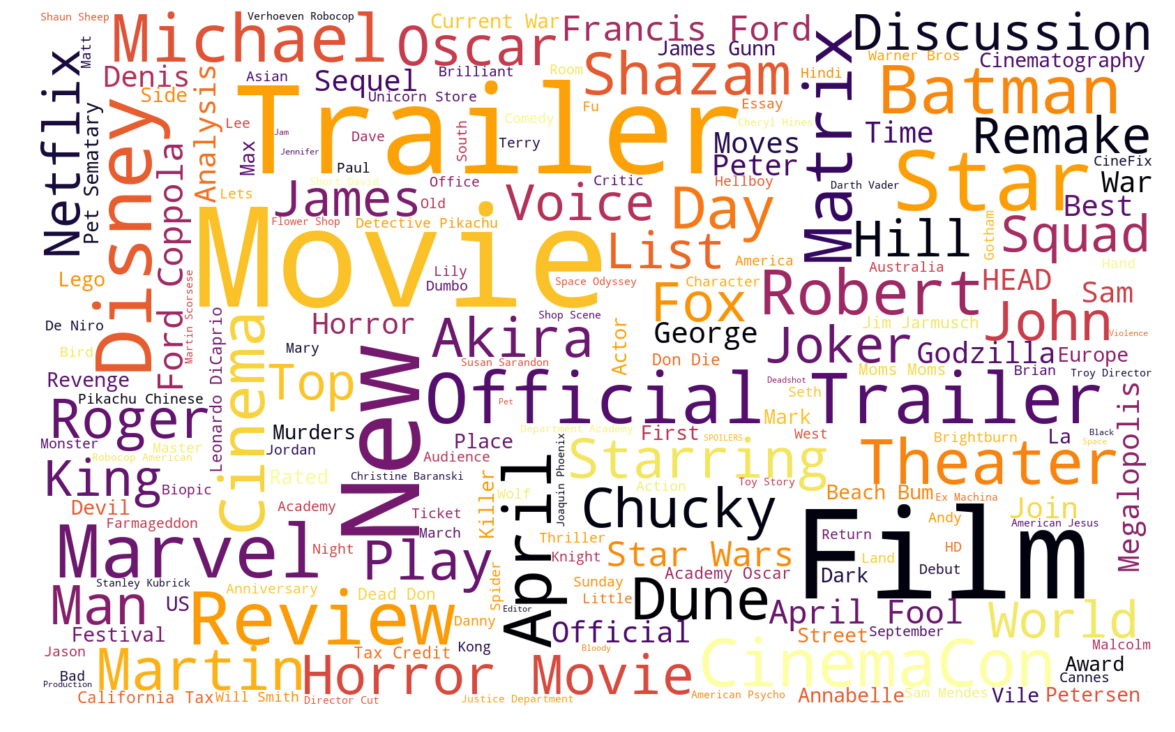

In [53]:
# returns a word cloud of movie related words using proper nouns
class_zero = train[train['is_tv'] == 0]
zero_string = []
for t in class_zero.pnouns_from_lemmed:
    zero_string.append(t)
zero_string = pd.Series(zero_string).str.cat(sep=' ')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(width=1600, height=1000,
                      max_font_size=200,
                      colormap='inferno', 
                      background_color='white').generate(zero_string)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Barplots

In [54]:
# Extracting words from each document

# Instantiate Tokenizer
tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b') # Regex here says to get full words but exclude digits

# Tokenizer Texts
dirty_text_tokens = [tokenizer.tokenize(token.lower().strip()) for token in train['posts_combined']]

# Initialize master list to populate
master_text_tokens = []

# For each dirty text, get list of clean tokens and append to master_text_tokens
for text in dirty_text_tokens:
    # Create template for clean tokens to populate for this particular text
    clean_text_tokens = []
    # For each word/token in each document, make sure it is not a stopword 
    # or URL piece or main search term 
    for word in text:
        if ((word not in stopwords.words('english')) and (word not in ['http','https','www','com','@','...','…'])):
            # Now extract it into clean token list
            clean_text_tokens.append(word)
    # Append this list of tokens to the master list
    master_text_tokens.append(clean_text_tokens)

In [55]:
len(master_text_tokens)

2061

In [56]:
# "de-lists" a list of lists. 
# That is, turns a list of lists into a single list
full_list = master_text_tokens[0]

for sub_list in master_text_tokens[1:]:
    full_list.extend(sub_list)

In [57]:
full_list[0]

'official'

In [58]:
len(full_list)

15718

In [59]:
fdist = nltk.FreqDist(full_list)

In [60]:
fdist.most_common(10)

[('season', 183),
 ('tv', 150),
 ('movie', 133),
 ('series', 129),
 ('trailer', 113),
 ('netflix', 110),
 ('new', 106),
 ('show', 105),
 ('movies', 86),
 ('amp', 83)]

In [61]:
common = fdist.most_common(20)

In [62]:
word_freq = []
for word, freq in common:
    #print(word)
    common_words = {}
    common_words['words'] = word
    common_words['freq'] = freq
    word_freq.append(common_words)

In [63]:
common_words = pd.DataFrame(word_freq)
common_words.head()

freq    words
0   183   season
1   150       tv
2   133    movie
3   129   series
4   113  trailer

In [64]:
# Extracting words from each document
def extractor(data):
    # Instantiate Tokenizer
    tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b') # Regex here says to get full words but exclude digits

    # Tokenizer Texts
    dirty_text_tokens = [tokenizer.tokenize(token.lower().strip()) for token in data]

    # Initialize master list to populate
    master_text_tokens = []

    # For each dirty text, get list of clean tokens and append to master_text_tokens
    for text in dirty_text_tokens:
        # Create template for clean tokens to populate for this particular text
        clean_text_tokens = []
        # For each word/token in each document, make sure it is not a stopword 
        # or URL piece or main search term 
        for word in text:
            if ((word not in stopwords.words('english')) and (word not in ['http','https','www','com','@','...','…'])):
                # Now extract it into clean token list
                clean_text_tokens.append(word)
        # Append this list of tokens to the master list
        master_text_tokens.append(clean_text_tokens)
        
    return master_text_tokens 




In [68]:
pnouns_list = extractor(train['pnouns_from_lemmed'])

In [70]:
pnouns_full_list = pnouns_list[0]

for s_list in pnouns_list[1:]:
    pnouns_full_list.extend(s_list)

In [72]:
pnouns_full_list[10]

'office'

In [73]:
len(pnouns_full_list)

7443

In [74]:
fdist_n = nltk.FreqDist(pnouns_full_list)

In [76]:
common_pnouns = fdist_n.most_common(20)

In [77]:
word_freq = []
for word, freq in common_pnouns:
    #print(word)
    pnoun_common_words = {}
    pnoun_common_words['words'] = word
    pnoun_common_words['freq'] = freq
    word_freq.append(pnoun_common_words)

In [78]:
common_words_pnouns = pd.DataFrame(word_freq)
common_words_pnouns.head()

freq     words
0   131    season
1    93   netflix
2    80    series
3    73   trailer
4    58  twilight

In [81]:
import seaborn as sns

In [82]:
## Define a function that plots most common words
def plotter(x, y, part_of_speech):
    plt.figure(figsize=(10, 7))
    sns.barplot(x,
                y,  
                orient='h', color='b')
    plt.title(f'20 Most Common Words ({part_of_speech})', fontsize=18, )
    plt.xlabel('Frequency', fontsize=16)
    plt.ylabel('Words', fontsize=16);

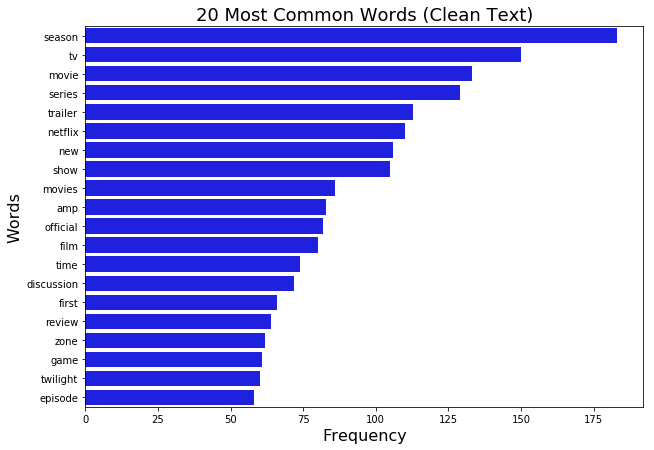

In [83]:
plotter(common_words['freq'],
        common_words['words'],
       'Clean Text')

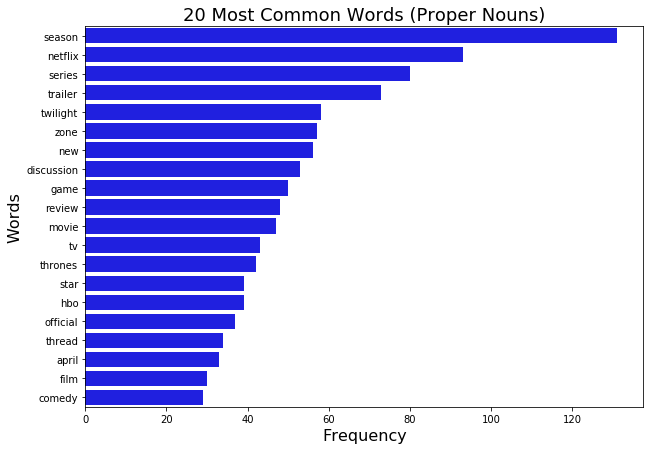

In [85]:
plotter(common_words_pnouns['freq'], common_words_pnouns['words'], 'Proper Nouns')

In [88]:
# saving the data to the data directory
train.to_csv('./data/train_clean.csv', index=False)